In [4]:
# import necessary packages

import pandas as pd
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer

import seaborn as sns
sns.set(color_codes=True)

# 1. Data Cleaning

- selected the column that we are interested in
- delete all records with missing indicator ( hard to fill in)
- fill in missing data with median of the corresponding column



In [5]:
# Read in data
data = pd.read_sas('rpsdata_rfs.sas7bdat')

In [6]:
# 1. keep column needed
col_selected = pd.read_excel("selected_column.xlsx")
col_set = col_selected['col_name']
data_selected = data.loc[:,col_set]

In [7]:
# Subset of the data for computation convenience
data_selected=data_selected.iloc[-500000:,:]

In [8]:
# 2. delete missing indicator
indx_null_indicator = np.isnan(data_selected["rd"])
data_delete_nanindicator = data_selected.loc[~indx_null_indicator, :].reset_index(drop=True)

In [9]:
# 3. Use mean to fill missing value
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(data_delete_nanindicator)
clean_data = imp.transform(data_delete_nanindicator)
clean_data_df = pd.DataFrame(clean_data,columns = data_delete_nanindicator.columns)

In [10]:
clean_data_df.head()

,zerotrade,turn,tb,tang,stdcf,stdacc,std_turn,std_dolvol,sp,sin,...,baspread,agr,age,aeavol,acc,absacc,divo,divi,ms,sue
0,2.638298e-08,1.207300,-0.213019,0.513134,0.155017,0.128632,1.096981,0.275083,0.594008,0.0,...,0.014184,0.073725,31.0,0.801490,-0.001170,0.001170,0.0,0.0,3.0,0.004337
1,3.150000e+00,0.112370,-0.158269,0.574399,0.152979,0.165974,0.396336,1.227306,4.367654,0.0,...,0.021860,-0.171288,31.0,0.958727,0.082283,0.082283,0.0,0.0,1.0,-0.146176
2,1.815602e-08,1.290598,0.252265,0.556603,0.068953,0.063876,4.055837,0.441789,1.099558,0.0,...,0.019166,0.083671,32.0,0.226344,-0.060724,0.060724,0.0,0.0,6.0,0.000365
3,9.217671e-09,1.001093,0.366359,0.625939,0.233632,0.230561,16.824787,1.132024,4.215534,0.0,...,0.055269,-0.160982,22.0,0.342599,-0.350300,0.350300,0.0,0.0,5.0,0.000655
4,1.250533e-07,0.215323,-0.039294,0.466748,0.155017,0.128632,0.581826,0.616163,0.151683,0.0,...,0.015267,0.127342,31.0,0.427552,0.066734,0.066734,0.0,0.0,2.0,0.033744


In [11]:
dataset = clean_data_df.copy()

# correct the date column
temp = pd.to_timedelta(dataset['DATE'], unit='D') + pd.datetime(1960, 1, 1)
dataset['DATE']=temp.values

# add year and month column
dataset['year'] = pd.DatetimeIndex(dataset['DATE']).year
dataset['month'] = pd.DatetimeIndex(dataset['DATE']).month

In [22]:
# delete data before 1988 - keep 30year's data
clean_data_after1988 = dataset[dataset['year']>=1988].reset_index(drop=True)


# delete data with market cap < 500million 
# for a company, all the records after its market cap hit 500m for the frist time will be kept
def dataprocess_mktcap(groupdata):
    groupdata = groupdata.sort_values(['DATE'])
    indx = next((i for i in range(len(groupdata['mve_m'])) if groupdata['mve_m'].values[i] >=500000),len(groupdata['mve_m']))
    groupdata = groupdata.iloc[indx:,:] 
    return groupdata

    
clean_data_mktcap = clean_data_after1988.groupby(['permno'], as_index=False).apply(dataprocess_mktcap)
clean_data_mktcap = clean_data_mktcap.reset_index(drop = True)

In [38]:
# Preparation for Calculating the VIF, Cell added by Leon
#clean_data_mktcap['mve']=np.log(clean_data_mktcap['mve_m'])

clean_data_mktcap_vif=clean_data_mktcap.drop(['RET','mve_m','pricedelay','permno','DATE','datadate'],axis=1)

clean_data_mktcap_vif=clean_data_mktcap_vif.drop(['betasq', 'dolvol', 'lgr', 'maxret', 'mom6m', 'pchquick', 'quick', 'stdacc'],axis=1)


from statsmodels.stats.outliers_influence import variance_inflation_factor
non_float=clean_data_mktcap_vif.dtypes[clean_data_mktcap_vif.dtypes!='float64'].index
data_float=clean_data_mktcap_vif.drop(non_float,axis=1)
data_float=data_float.dropna(how='any',axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_float.values, i) for i in range(data_float.shape[1])]
vif["features"] = data_float.columns

# Select Variables that have high VIF value
vif[vif['VIF Factor']>7]
high_corr_variables=vif[vif['VIF Factor']>7]['features'].tolist()

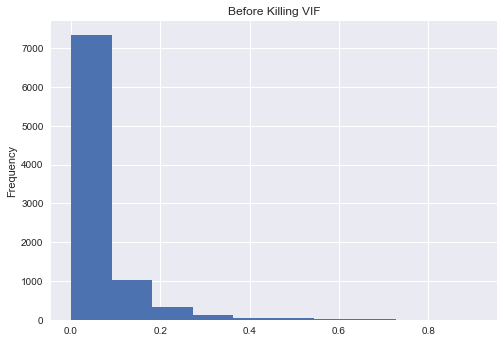

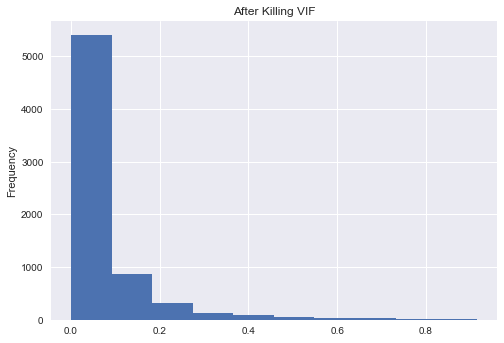

In [112]:
# Plot the Cross Correlation, Cell added by Leon
corr_matrix=np.abs(clean_data_mktcap_vif.corr())
# Plot the original correlation matrix
corr_values=corr_matrix.values.ravel()
corr_values=corr_values[corr_values!=1]
pd.DataFrame(corr_values).plot.hist(legend=False,title='Before Killing VIF')
plt.show()


# Plot the correlation matrix after killing the high VIF Variables
killed_corr_matrix=corr_matrix.drop(high_corr_variables,axis=1)
killed_corr_matrix=np.abs(killed_corr_matrix.corr())
killed_corr_values=killed_corr_matrix.values.ravel()
killed_corr_values=killed_corr_values[killed_corr_values!=1]

pd.DataFrame(killed_corr_values).plot.hist(legend=False,title='After Killing VIF')
plt.show()


# 2.1 Factor Prepare

- Assign the factors into different categories (not very accurate here)

In [57]:
col_info= pd.read_excel("selected_column.xlsx")
col_info.head()

# create dictionary for acronym
factor_dicts = {}
keys = col_info['col_name'].values.tolist()
values = col_info['description'].values.tolist()
for i in range(len(keys)):
    factor_dicts[keys[i]] = values[i]


col_info.set_index(['factor_type','col_name'])



type  \
factor_type   col_name                  
change        chfeps           factor   
              pchsaleinv       factor   
              pchsale_pchinvt  factor   
              chnanalyst       factor   
              pchsale_pchxsga  factor   
              chatoia          factor   
              chtx             factor   
              pchdepr          factor   
              pchquick         factor   
              pchsale_pchrect  factor   
              pchcurrat        factor   
              pchcapx_ia       factor   
              chinv            factor   
              chpmia           factor   
              pchgm_pchsale    factor   
              chmom            factor   
              chempia          factor   
              chcsho           factor   
dividend      dy               factor   
growth        fgr5yr           factor   
              grltnoa          factor   
              grcapx           factor   
              sgr              factor   
              lgr              factor   
              hire             factor   
              egr              factor   
              agr              factor   
info          pricedelay         info   
              IPO                info   
              age                info   
...                               ...   
quality-ratio salecash         factor   
              lev              factor   
              sp               factor   
              salerec          factor   
              cashdebt         factor   
              rd_sale          factor   
              rd_mve           factor   
              saleinv          factor   
              tb               factor   
              cfp_ia           factor   
              cfp              factor   
size          mve_ia           factor   
value         bm_ia            factor   
              ep               factor   
              bm               factor   
volatility    stdcf            factor   
              stdacc           factor   
              roavol           factor   
              nanalyst         factor   
              idiovol          factor   
              betasq           factor   
              BETA             factor   
              retvol           factor   
info          datadate           info   
              permno             info   
              RET                info   
              DATE               info   
              mve                info   
quality-other securedind       factor   
size          mve_m            factor   

                                                                     description  
factor_type   col_name                                                            
change        chfeps                                    Change in forecasted EPS  
              pchsaleinv                             % change sales-to-inventory  
              pchsale_pchinvt          % change in sales - % change in inventory  
              chnanalyst                            Change in number of analysts  
              pchsale_pchxsga               % change in sales - % change in SG&A  
              chatoia                 Industry-adjusted change in asset turnover  
              chtx                                         Change in tax expense  
              pchdepr                                   % change in depreciation  
              pchquick                                   % change in quick ratio  
              pchsale_pchrect                % change in sales - % change in A/R  
              pchcurrat                                % change in current ratio  
              pchcapx_ia       Industry adjusted % change in capital expendit...  
              chinv                                          Change in inventory  
              chpmia                   Industry-adjusted change in profit margin  
              pchgm_pchsale         % change in gross margin - % change in sales  
              chmom                   

In [86]:
factor_type = col_info[['factor_type','col_name']].groupby(['factor_type']).count()
factor_type


,col_name
factor_type,
change,18
dividend,1
growth,8
info,8
liquidity,9
momentum,6
quality-accrual,3
quality-balancesheet,9
quality-forecast,2


# 2.2 Check Data Distribution by factor type

In [89]:
def distribution_check(factor_type_name):
    check_col = col_info[col_info['factor_type']== factor_type_name]['col_name']
    for col in check_col:
        plt.figure()
        sns.distplot(clean_data_mktcap[col])
        plt.title(factor_dicts[col])

        plt.show()
    

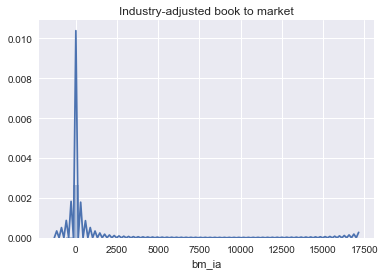

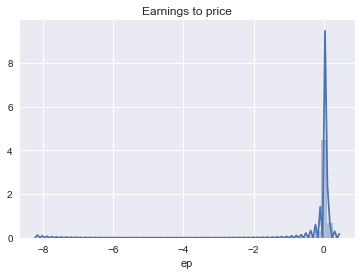

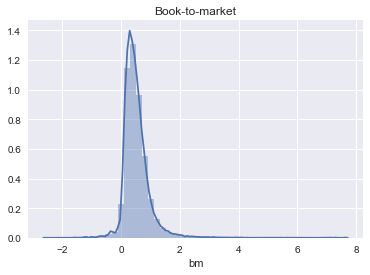

In [90]:
# type - value
distribution_check('value')

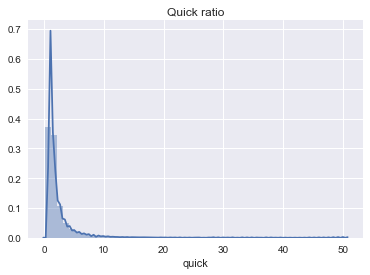

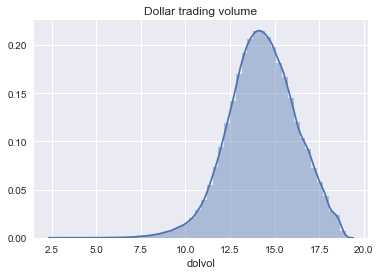

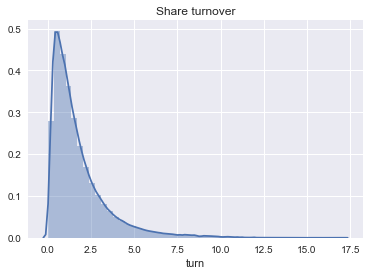

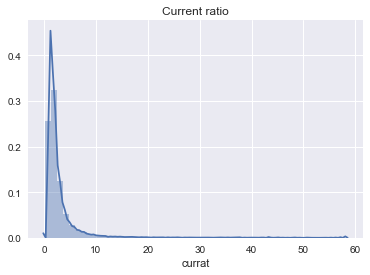

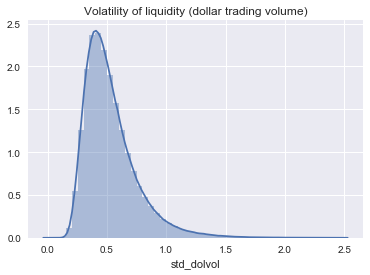

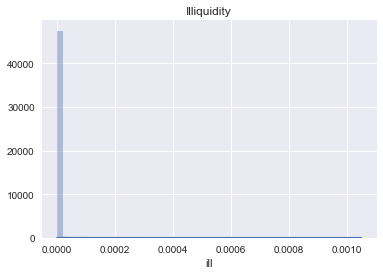

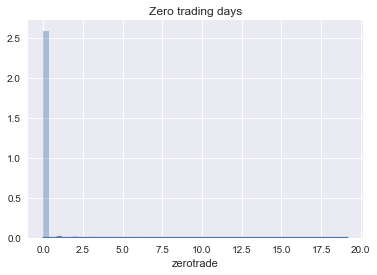

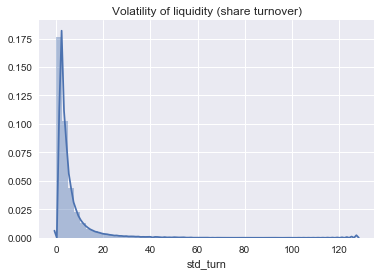

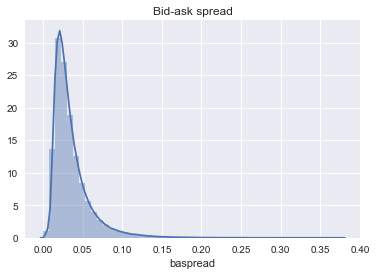

In [91]:
# type - liquidity
distribution_check('liquidity')
    
# for col in check_col:
#     fig = plt.figure()
#     ax1 = fig.add_subplot(121)
#     ax2 = fig.add_subplot(122)

#     sns.distplot(clean_data_mktcap[col], ax=ax1)
#     sns.regplot(x= col , y='RET', data=clean_data_mktcap, ax=ax2)
#     plt.suptitle(factor_dicts[col])
#     plt.show()

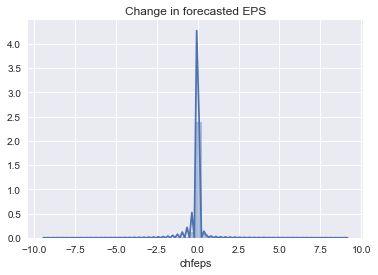

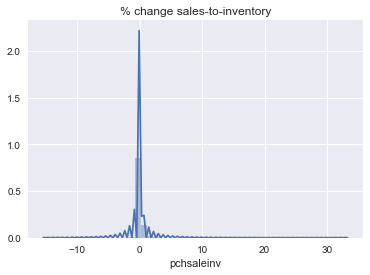

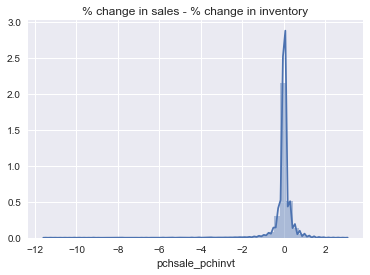

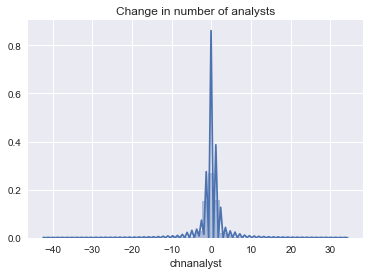

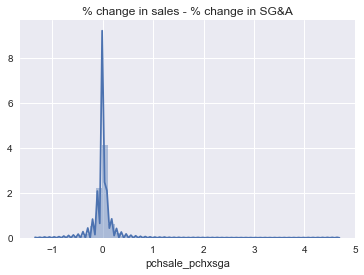

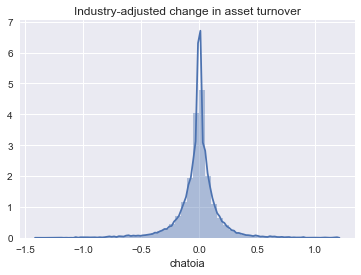

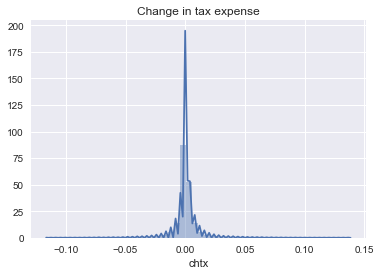

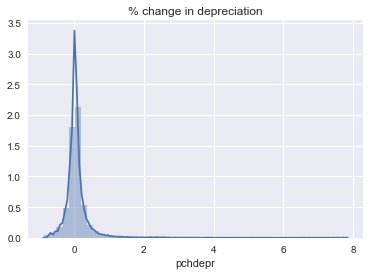

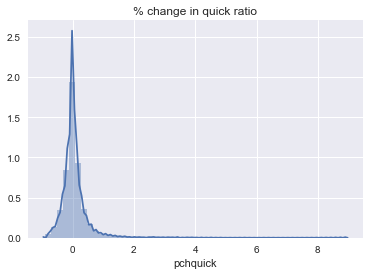

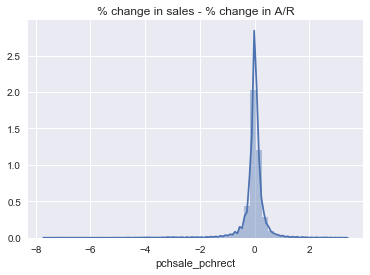

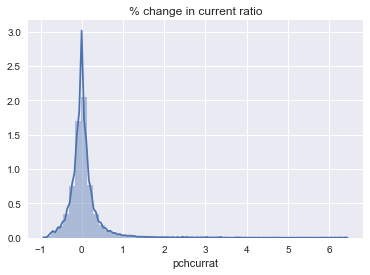

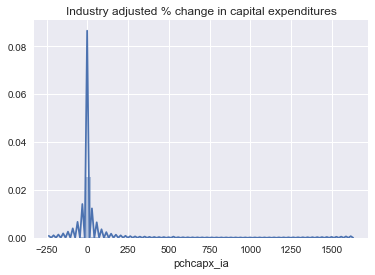

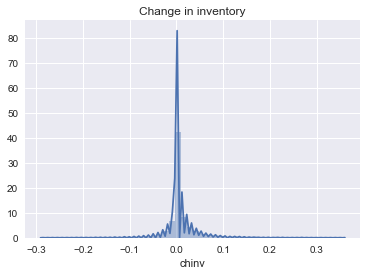

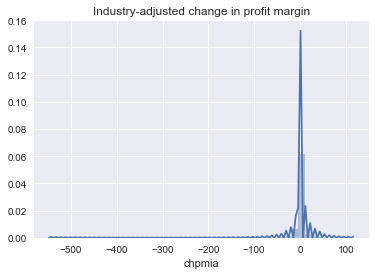

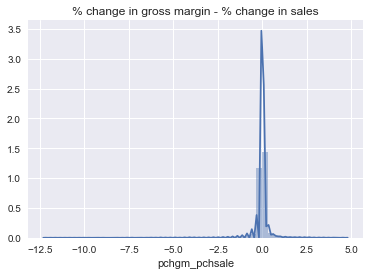

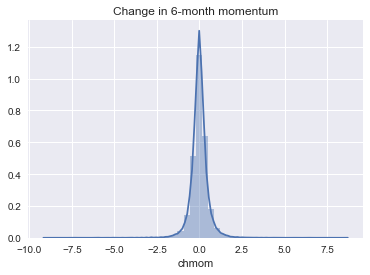

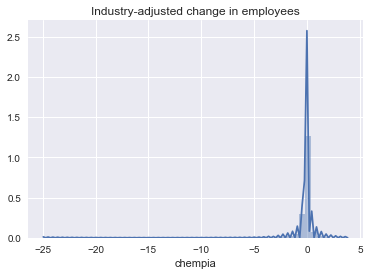

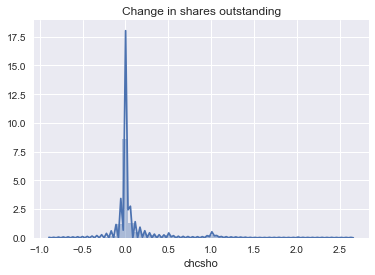

In [92]:
# type - change
distribution_check('change')

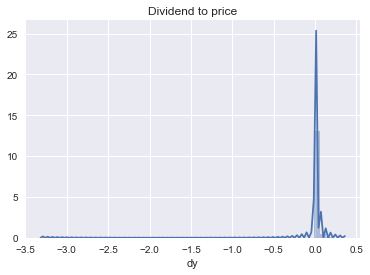

In [93]:
distribution_check('dividend')

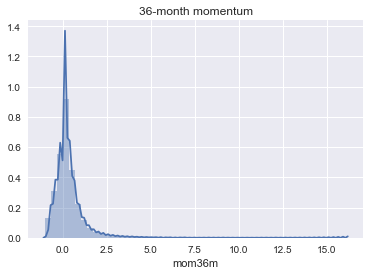

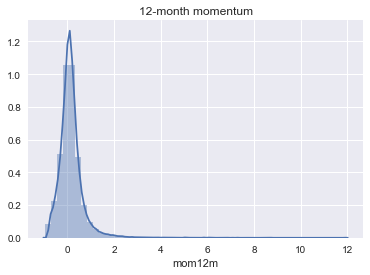

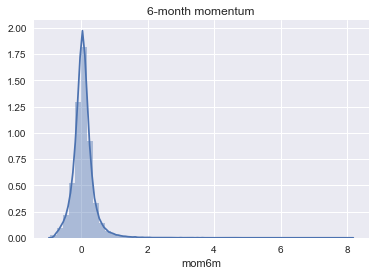

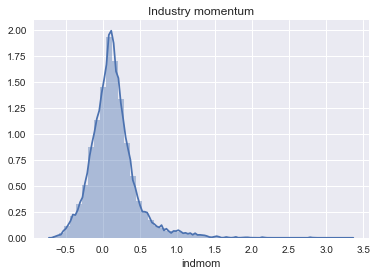

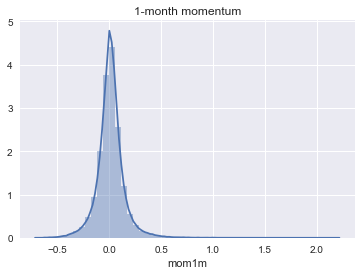

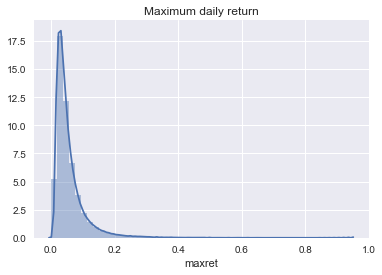

In [94]:
distribution_check('momentum')

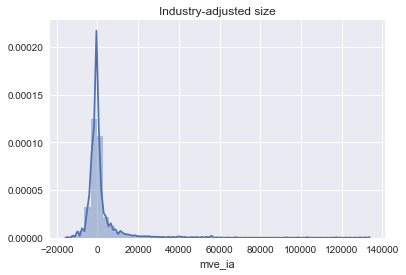

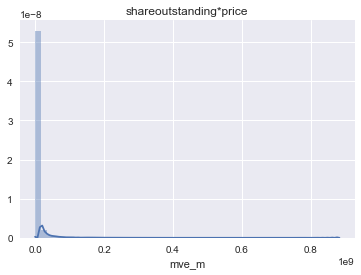

In [95]:
distribution_check('size')

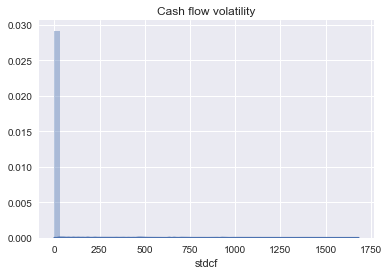

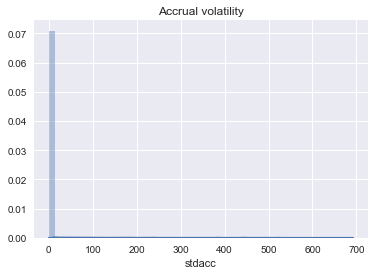

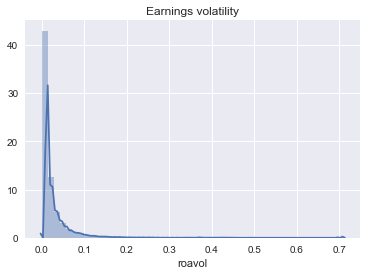

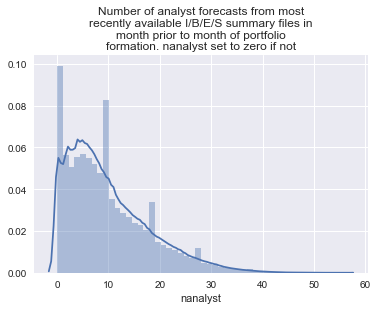

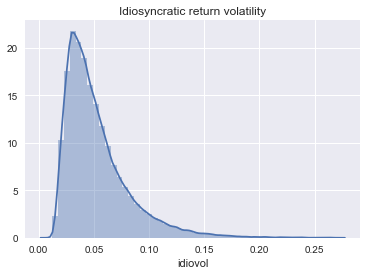

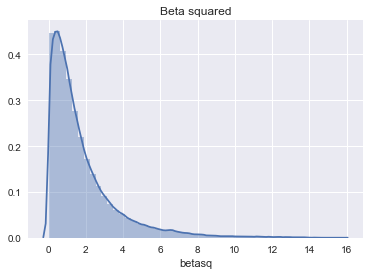

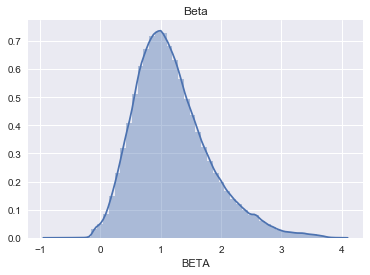

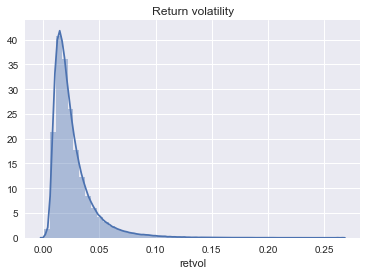

In [96]:
distribution_check('volatility')

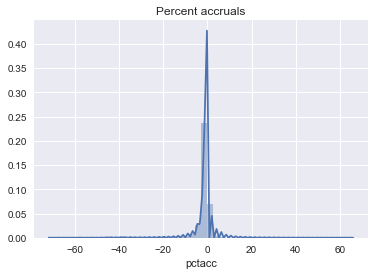

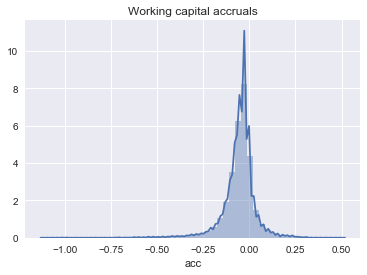

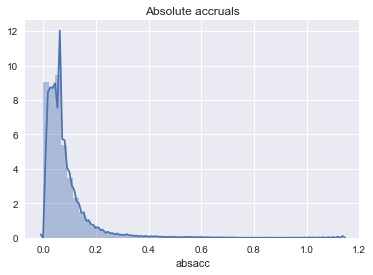

In [97]:

distribution_check('quality-accrual')

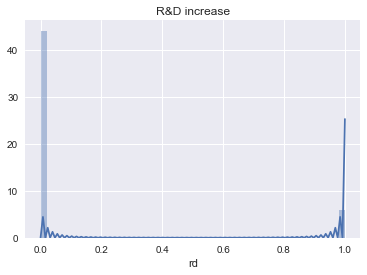

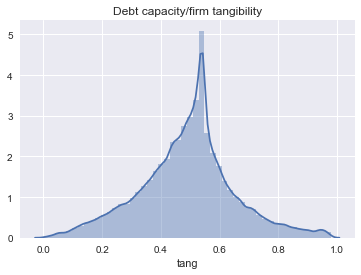

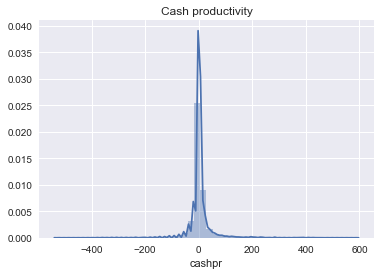

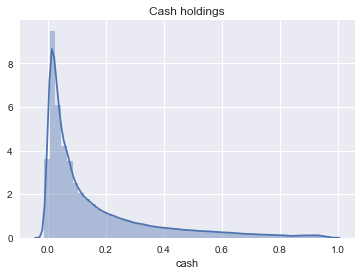

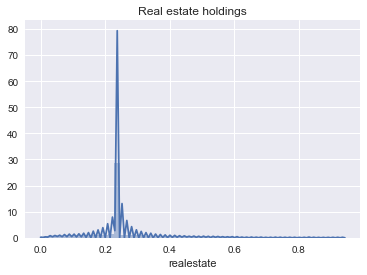

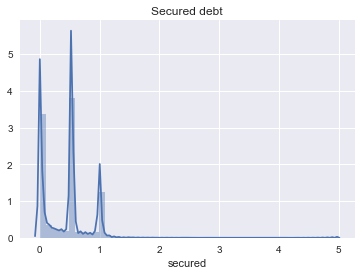

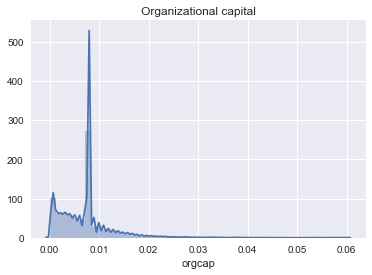

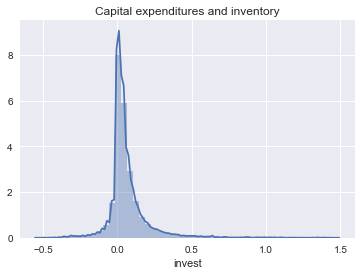

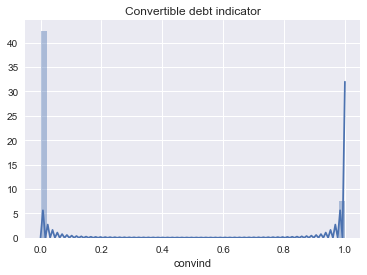

In [98]:
distribution_check('quality-balancesheet')

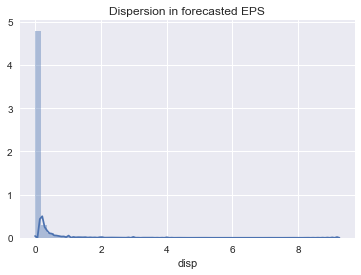

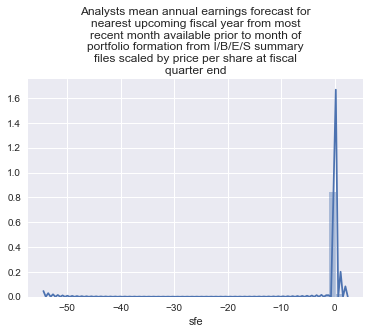

In [99]:
distribution_check('quality-forecast')                 

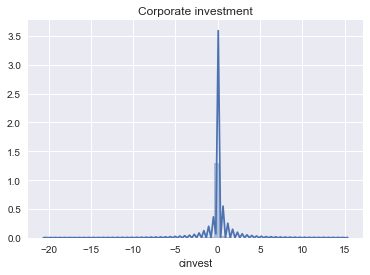

In [100]:
distribution_check('quality-investment')

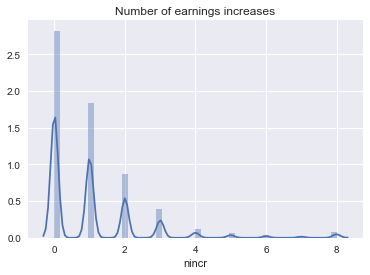

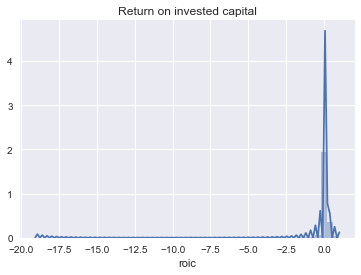

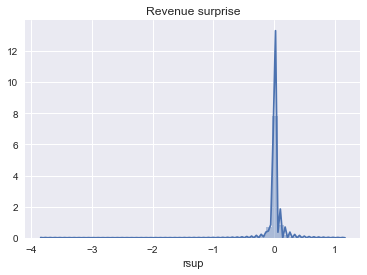

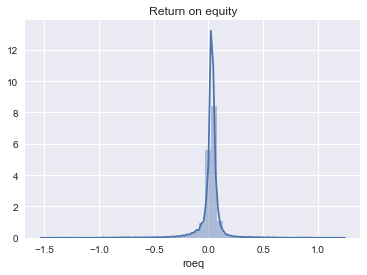

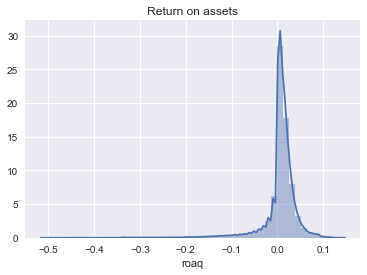

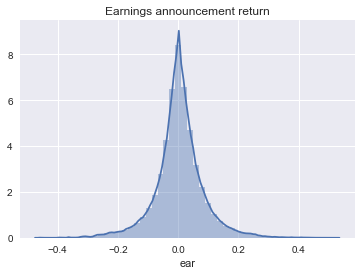

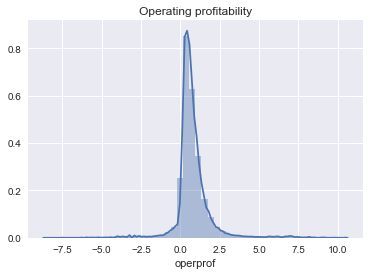

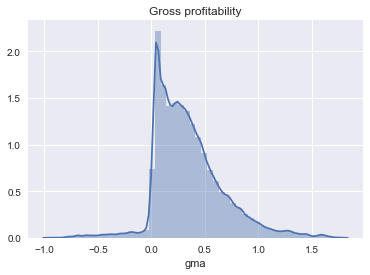

In [101]:
distribution_check('quality-profit')

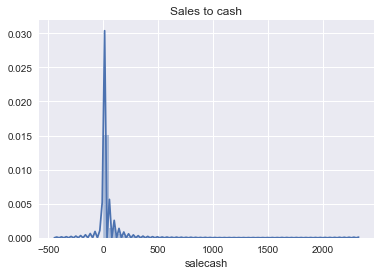

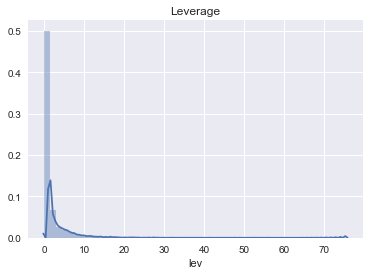

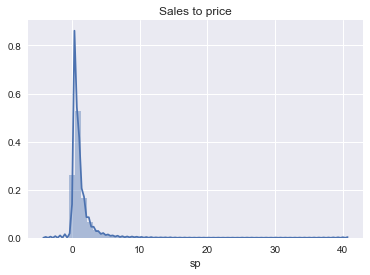

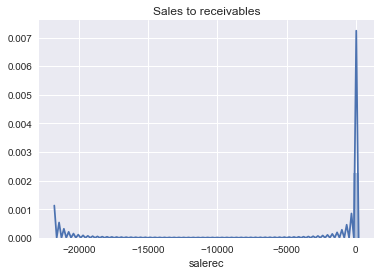

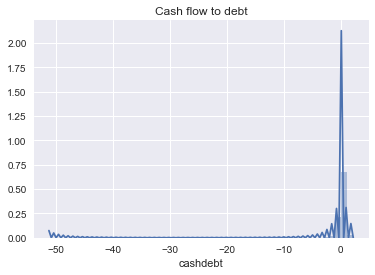

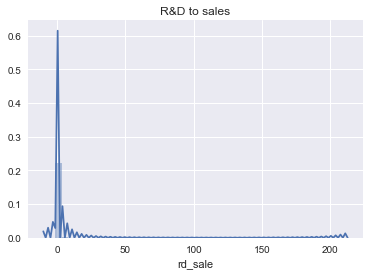

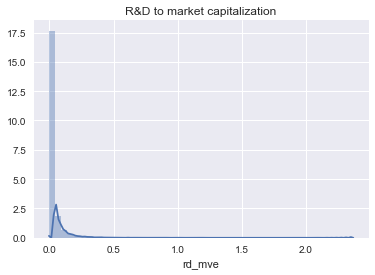

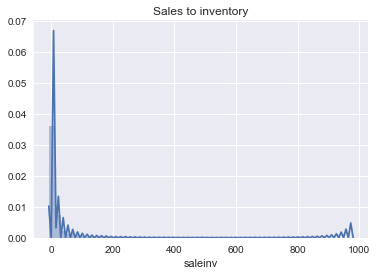

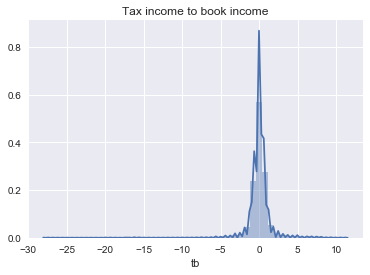

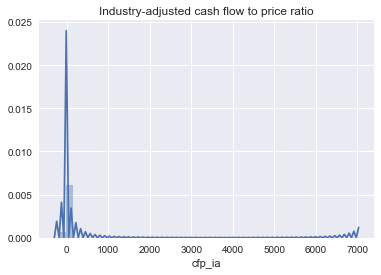

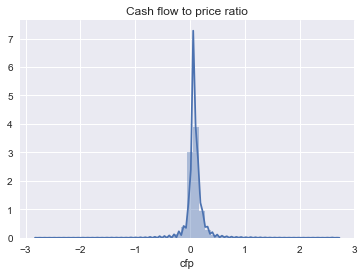

In [102]:
distribution_check('quality-ratio')

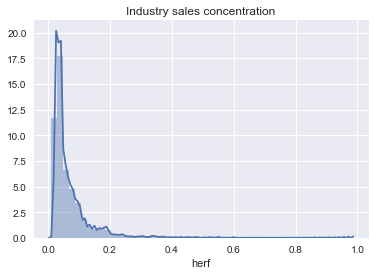

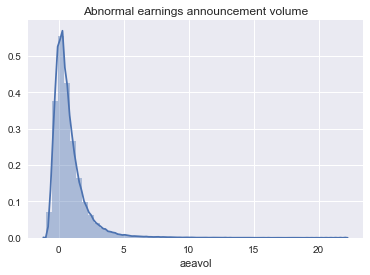

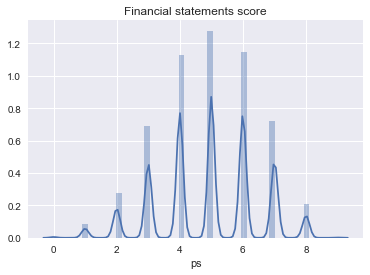

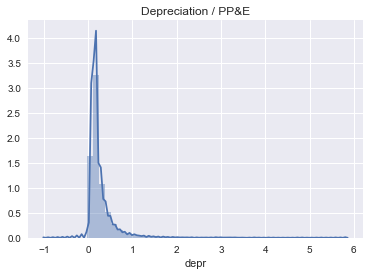

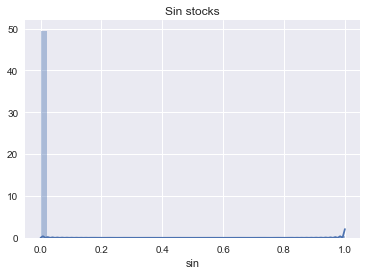

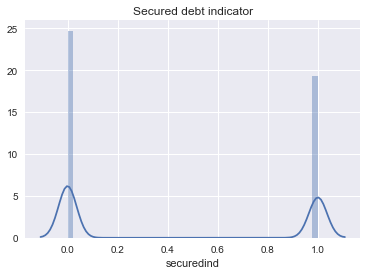

In [103]:
distribution_check('quality-other')